In [1]:
%matplotlib inline
from defs import *

In [2]:
counts_data=df=pd.read_excel('data_Ilan_Gospels_Josephus_Apocrypha.xlsx')
# Example usage
df_display(df, head=10, tail=10)

,Name,Ilan,Gospels,Josephus,Apocrypha
0,Simon,184,8,21,9
1,Joseph,171,6,16,9
2,Eleazar,135,1,15,4
3,Judah,126,5,10,7
4,Yohanan,103,5,9,5
5,Hananiah,74,2,10,3
6,Joshua,68,2,12,2
7,Jonathan,56,1,7,1
8,Mattathias,50,2,7,3
9,Jacob,30,5,4,6


In [3]:
def ilan_uniform_mixture_model(y=None, y_exp=None, N=None, K=None,m=None):

    if m==0:
        # Dirichlet prior for the first m categories
        # Uniform probabilities for the remaining K-m categories
        theta_uniform = numpyro.deterministic("theta_uniform", np.ones(K) / K)
        # Combine the two components into a single probability vector
        theta = numpyro.deterministic("theta", theta_uniform)

    else:
        # Dirichlet prior for the first m categories
        alpha = numpyro.sample("alpha", dist.Exponential(1.0).expand([m]))
        theta_dirichlet = numpyro.sample("theta_dirichlet", dist.Dirichlet(alpha))
        
        # Uniform probabilities for the remaining K-m categories
        theta_uniform = numpyro.deterministic("theta_uniform", np.ones(K - m) / (K - m))

        # Weight parameter: how much mass goes to the first m categories
        w = numpyro.sample("w", dist.Beta(2, 2))  # optional: can fix to 0.5 if you prefer
    
        
        # Combine the two components into a single probability vector
        theta = numpyro.deterministic("theta", jnp.concatenate([w * theta_dirichlet, (1-w)*theta_uniform]))

    with numpyro.plate("data_y_exp", len(y_exp)):
        numpyro.sample("y_exp", dist.Categorical(probs=theta), obs=y_exp)    

    with numpyro.plate("data_y", len(y)):
        numpyro.sample("y", dist.Categorical(probs=theta), obs=y)    


In [4]:
cols=df.columns
cols

Index(['Name', 'Ilan', 'Gospels', 'Josephus', 'Apocrypha'], dtype='object')

In [5]:
for col in cols[2:]:

    print(col)
    
    sample=df[col].values
    population=df['Ilan'].values-sample
    population[population<0]=0  # one weird name in apocrypha, because of the way I am using Ilan
    
    names=df['Name'].values    
    
    K = len(sample)  # Number of categories
    N = sum(sample)  # Total number of observations
    y_obs=sample
    y_exp=population


    S=Storage()
    mm=list(arange(0,30))
    

    for m in tqdm(mm):   
        mcmc=MCMCModel(ilan_uniform_mixture_model)
        mcmc.run(num_warmup=1000, num_samples=4000,progress_bar=False,
                 y=y_obs,y_exp=y_exp,N=N,K=K,m=m)


        log_lik_values = mcmc.log_likelihood["y"].reshape(1,mcmc.mcmc_dme.num_samples,-1)
        posterior_np = {k: np.asarray(v).reshape(1,mcmc.mcmc_dme.num_samples,-1) for k, v in mcmc.samples.items()}
        log_lik_np = {"y": np.asarray(log_lik_values)}  # pointwise log-likelihood
        idata = az.from_dict(posterior=posterior_np, log_likelihood=log_lik_np)
        result=az.loo(idata, pointwise=True)
        
        S+=m,result.elpd_loo,int(sum(result.pareto_k>0.7)),result.se
    
    m,elpd,bad,se=S.arrays()
    
    break
    

Gospels


  0%|                                                    | 0/30 [00:00<?, ?it/s]/Users/bblais/venvs/work/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
100%|███████████████████████████████████████████| 30/30 [02:10<00:00,  4.35s/it]


<ErrorbarContainer object of 3 artists>

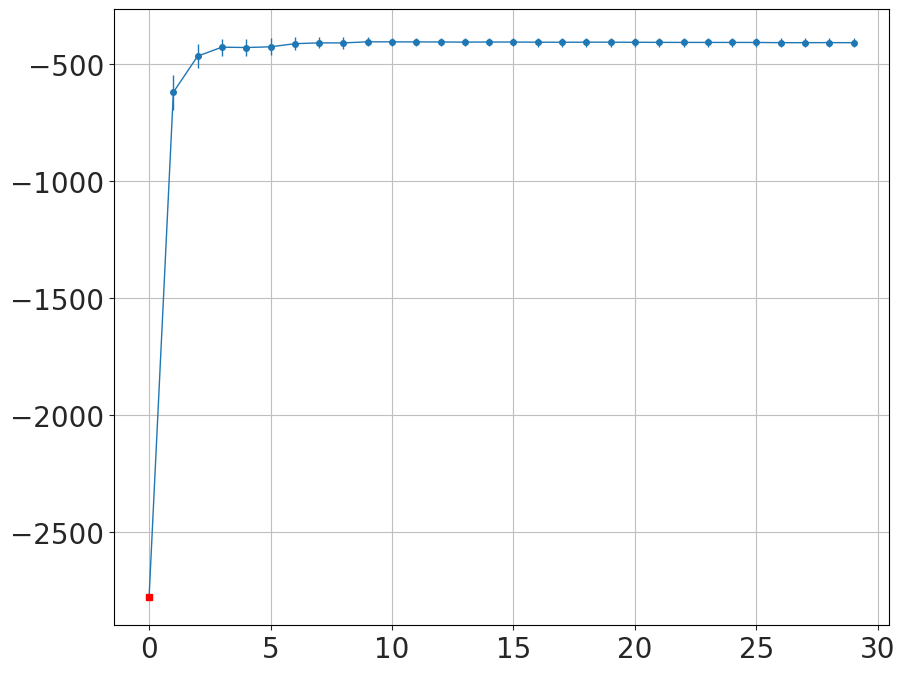

In [6]:
n=0
errorbar(m[n:],elpd[n:],yerr=2*se[n:],marker='o',ms=4,lw=1)
errorbar(m[n:][bad[n:]!=0],elpd[n:][bad[n:]!=0],yerr=2*se[n:][bad[n:]!=0],marker='s',color='r',ms=4,lw=1)

In [7]:
result_full={}

In [8]:
for col in cols[2:]:

    print(col)
    
    sample=df[col].values
    population=df['Ilan'].values-sample
    population[population<0]=0  # one weird name in apocrypha, because of the way I am using Ilan    
    names=df['Name'].values    
    
    if col in result_full:
        print("Already done",col)
        continue

    
    K = len(sample)  # Number of categories
    N = sum(sample)  # Total number of observations
    y_obs=sample
    y_exp=population


    S=Storage()
    mm=list(arange(0,K))
    if K not in mm:
        mm.append(K)
    

    for m in tqdm(mm):   
        mcmc=MCMCModel(ilan_uniform_mixture_model)
        mcmc.run(num_warmup=100, num_samples=2000,progress_bar=False,
                 y=y_obs,y_exp=y_exp,N=N,K=K,m=m)
        
        log_lik_values = mcmc.log_likelihood["y"].reshape(1,mcmc.mcmc_dme.num_samples,-1)
        posterior_np = {k: np.asarray(v).reshape(1,mcmc.mcmc_dme.num_samples,-1) for k, v in mcmc.samples.items()}
        log_lik_np = {"y": np.asarray(log_lik_values)}  # pointwise log-likelihood
        idata = az.from_dict(posterior=posterior_np, log_likelihood=log_lik_np)
        result=az.loo(idata, pointwise=True)
        
        S+=m,result.elpd_loo,int(sum(result.pareto_k>0.7)),result.se
    
    m,elpd,bad,se=S.arrays()

    result_full[col]=m,elpd,bad,se
    

Gospels


  0%|                                                   | 0/455 [00:00<?, ?it/s]/Users/bblais/venvs/work/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
100%|███████████████████████████████████████| 455/455 [1:11:49<00:00,  9.47s/it]


Josephus


  0%|                                                   | 0/455 [00:00<?, ?it/s]/Users/bblais/venvs/work/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
  4%|█▍                                        | 16/455 [00:40<21:06,  2.88s/it]/Users/bblais/venvs/work/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This i

Apocrypha


  0%|                                                   | 0/455 [00:00<?, ?it/s]/Users/bblais/venvs/work/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
 10%|████                                      | 44/455 [02:35<30:27,  4.45s/it]/Users/bblais/venvs/work/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This i

In [16]:
from json_tricks import dump,load

In [17]:
with open("loo_result_full_2025-06-27.json", "w") as f:
    dump(result_full, f, indent=4)

In [18]:
with open("loo_result_full_2025-06-27.json") as f:
    res=load(f)

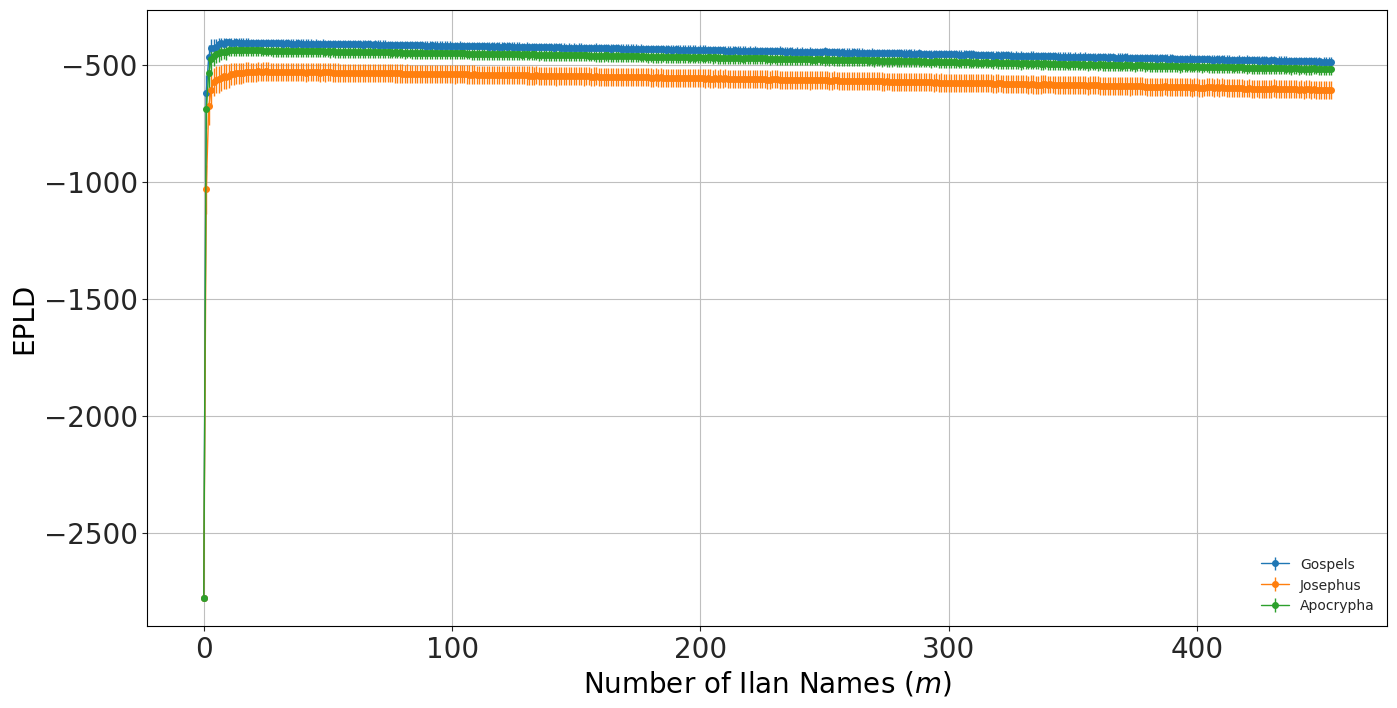

In [19]:
n=0
figure(figsize=(16,8))
for col in res:
    m,elpd,bad,se=res[col]
    errorbar(m[n:],elpd[n:],yerr=2*se[n:],marker='o',ms=4,lw=1,label=col)
    #errorbar(m[n:][bad[n:]!=0],elpd[n:][bad[n:]!=0],yerr=2*se[n:][bad[n:]!=0],marker='s',color='r',ms=4,lw=1)
legend()
ylabel('EPLD')
xlabel('Number of Ilan Names ($m$)')    
legend(fontsize=10)

Gospels 9
Josephus 22
Apocrypha 10


(-1100.0, -350.0)

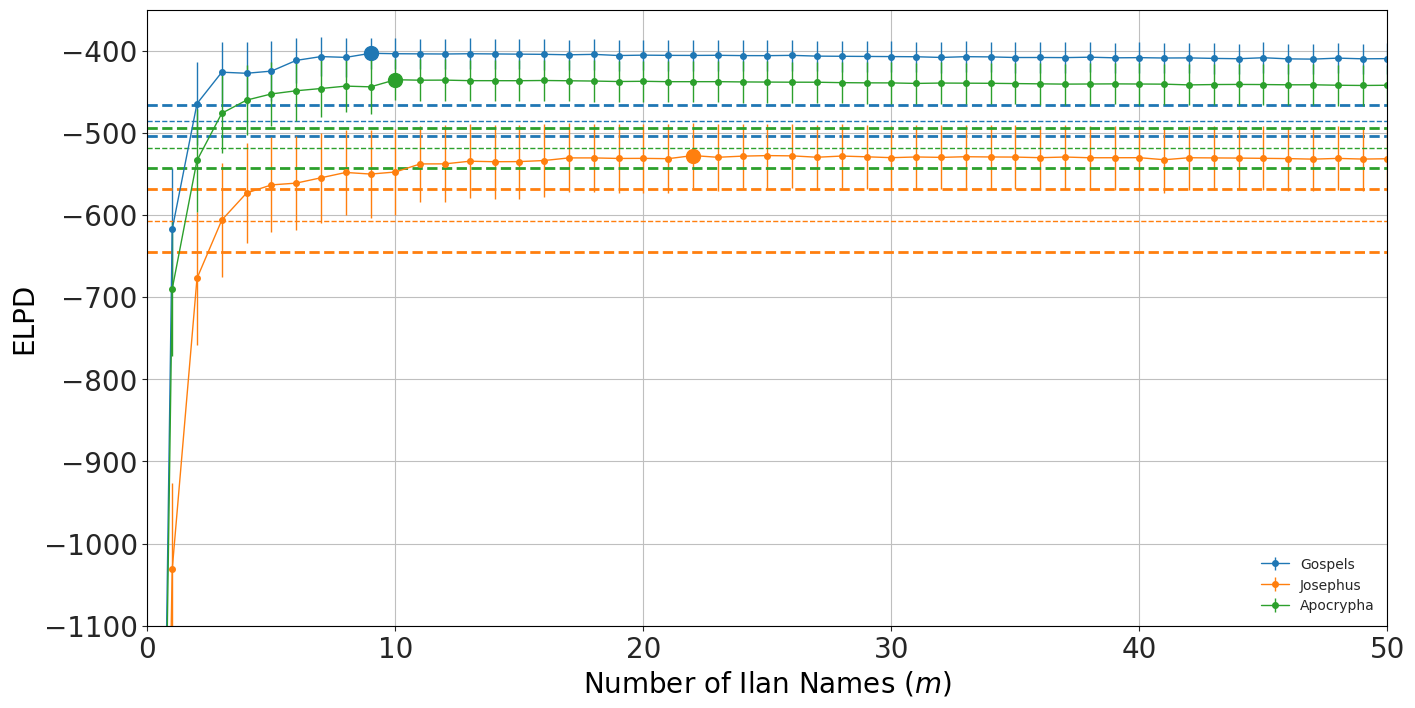

In [21]:
n=0
figure(figsize=(16,8))

for col in res:
    m,elpd,bad,se=res[col]
    h=errorbar(m[n:],elpd[n:],yerr=2*se[n:],marker='o',ms=4,lw=1,label=col)
    color=h[0].get_color()
    hlines(elpd[-1],0,400,linestyle='--',color=color,lw=1)
    hlines(elpd[-1]-2*se[-1],0,400,linestyle='--',color=color,lw=2)
    hlines(elpd[-1]+2*se[-1],0,400,linestyle='--',color=color,lw=2)

    idx=argmax(elpd)
    plot(m[idx],elpd[idx],'o',color=color,ms=10)
    print(col,m[argmax(elpd)])
    
    
legend()
ylabel('ELPD')
xlabel('Number of Ilan Names ($m$)')    
legend(fontsize=10)

xlim([0,50])
ylim([-1100,-350])

Gospels 9
Josephus 22
Apocrypha 10


(-1100.0, -350.0)

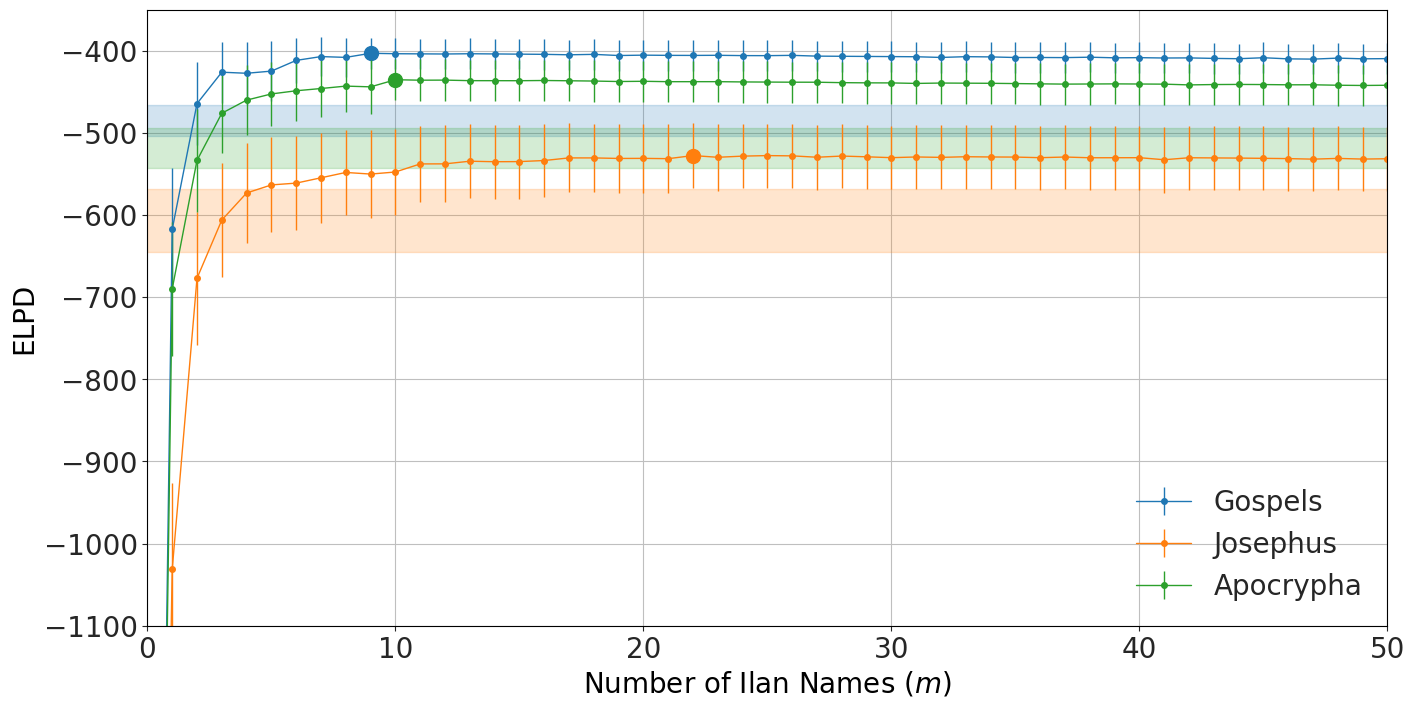

In [24]:
n=0
figure(figsize=(16,8))

for col in res:
    m,elpd,bad,se=res[col]
    h=errorbar(m[n:],elpd[n:],yerr=2*se[n:],marker='o',ms=4,lw=1,label=col)
    color=h[0].get_color()
    #hlines(elpd[-1],0,400,linestyle='--',color=color,lw=1)
    plt.fill_between(
        x=[0, 400],
        y1=elpd[-1] - 2 * se[-1],
        y2=elpd[-1] + 2 * se[-1],
        color=color,
        alpha=0.2
    )    

    idx=argmax(elpd)
    plot(m[idx],elpd[idx],'o',color=color,ms=10)
    print(col,m[argmax(elpd)])
    
    
legend()
ylabel('ELPD')
xlabel('Number of Ilan Names ($m$)')    
legend(fontsize=20)

xlim([0,50])
ylim([-1100,-350])